# Bicycle Location

Import the following modules

In [1]:
# Import

import numpy as np
import ujson
import pandas as pd
import matplotlib.pyplot as plt
import os
import random 
import json
import pickle

# Multi Criteria Decision Making

from skcriteria import Data, MIN, MAX
import itertools
from skcriteria.madm.moora import norm, rank
from skcriteria.madm.moora import *

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

## Part 1: Readind solutions from files

Select the number of stations

In [2]:
num_stations = 20       # 20 or 40

In [3]:
solutions = []

# Just one solution
for i in range(1,2):
    with open("results_" + str(num_stations) + "_b/RobustSols20"+str(i)+".json") as file:
        res_js = file.read()
        solutions.append(ujson.loads(res_js))
        

res_inter = []   # Bicycle - stations solutions idx
obj_1 = []       # Objective fn 1
obj_2 = []       # Objective fn 2 (MinDist) 


n_rob = 0
color = []
for i in range(len(solutions)):
    if i < 5:       
        n_rob = n_rob + len(solutions[i]) 
    for j in solutions[i].keys():
        res_inter.append(sorted(solutions[i][j]['IDs']))
        obj_1.append(-solutions[i][j]['Objective'])
        obj_2.append(solutions[i][j]['MinDist'])
        color.append(i)

## Part 2: Plot pareto front 

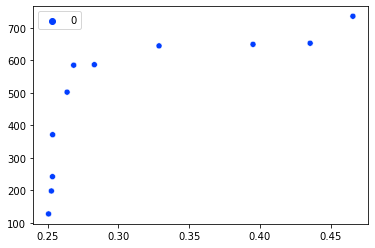

Text(0.5, 1.0, 'Pareto fronts')

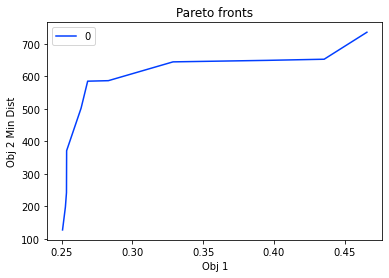

In [4]:
eliminar = set()
for i in range(len(obj_1)):
    for j in range(len(obj_1)):   
        if obj_1[i] >= obj_1[j] and i != j:
            if obj_2[i] >= obj_2[j]:
                eliminar.add(j)
        if obj_2[i] >= obj_2[j] and i != j:
            if obj_1[i] >= obj_1[j]:
                eliminar.add(j)

ob1 = np.array(obj_1)
ob1 = np.delete(ob1, list(eliminar))

ob2 = np.array(obj_2)
ob2 = np.delete(ob2, list(eliminar))

# Pareto Front of all solutions
sns.scatterplot(x = obj_1, y = obj_2, hue = color, palette = 'bright')
sns.lineplot(x = ob1, y = ob2)
#sns.scatterplot(x = ob1, y = ob2)
plt.show()

sns.lineplot(x = obj_1, y = obj_2, hue = color, palette = 'bright')
plt.xlabel("Obj 1")
plt.ylabel("Obj 2 Min Dist")
plt.title("Pareto fronts")

## Part 3: AHP
Getting the weights of the sub criteria.

In [5]:
# Criteria
# Urban Life, User, Transport
categories = np.array([[1, 1, 1/3],
                       [1, 1, 1/2],
                       [3, 2, 1]])

# Sub criteria
# Green Areas, Tourism, Mall, Sport Centres
urban = np.array([[1,   3,   5,   2],
                  [1/3, 1,   1,   1/3],
                  [1/5, 1,   1,   1/3],
                  [1/2, 3,   3,   1]])
                 
# Density, School, Universities
user = np.array([[1,   4,   1/3],
                 [1/4, 1,   1/5],
                 [3,   5,    1]])

# Bike Lane, Bus Stop
transport = np.array([[1,   2],
                      [1/2, 1]]) 

In [6]:
w_c = (categories/categories.sum(axis = 0)).mean(axis = 1)

w_b = (urban/urban.sum(axis = 0)).mean(axis = 1)
w_u = (user/user.sum(axis = 0)).mean(axis = 1)
w_t = (transport/transport.sum(axis = 0)).mean(axis = 1)

# Obtain final weight of sub criteria 
w_bf = w_b * w_c[0]   # Urban sub criteria
w_uf = w_u * w_c[1]   # User sub criteria
w_tf = w_t * w_c[2]   # Transport sub criteria

print(w_bf)
print(w_uf)
print(w_tf)

[0.10068327 0.02526449 0.02181193 0.06284637]
[0.06847322 0.02322832 0.14920755]
[0.36565657 0.18282828]


In [7]:
# Metrics AHP

# Transport doesn't have metrics because there are 2 cols.

eig_c = np.linalg.eigvals(categories).max()
eig_b = np.linalg.eigvals(urban).max()
eig_u = np.linalg.eigvals(user).max()

eig_values = np.array([eig_c, eig_b, eig_u])
print('Eigen values')
print(eig_values)

print('Metric CI')
CI  = (eig_values-np.array([categories.shape[0], urban.shape[0], user.shape[0]]))/np.array([categories.shape[0]-1, urban.shape[0]-1, user.shape[0]-1])
print(*CI)

print('Metric RI')
RI = np.array([0.58, 0.90, 0.58]) # Obtained from table
print(*RI)

print('Metric CR')
CR = CI/RI
print(*CR)

Eigen values
[3.01829471+0.j 4.04880192+0.j 3.08576669+0.j]
Metric CI
(0.009147353644816558+0j) (0.01626730731881783+0j) (0.042883345628599745+0j)
Metric RI
0.58 0.9 0.58
Metric CR
(0.015771299387614755+0j) (0.01807478590979759+0j) (0.0739368028079306+0j)


### Final weights

In [8]:
w = np.concatenate((w_tf, [w_uf[0]], [w_bf[0]], [w_bf[2]], [w_uf[1]], [w_bf[3]], [w_bf[1]], [w_uf[2]]))
w

array([0.36565657, 0.18282828, 0.06847322, 0.10068327, 0.02181193,
       0.02322832, 0.06284637, 0.02526449, 0.14920755])

## Part 4. MCDM

In [12]:
matrix_rango = pd.read_csv('tif_files/matrix_rango.csv', sep=';').to_numpy()
#matrix_proximity = pd.read_csv('tif_files/matrix_proximity.csv', sep=';').to_numpy()
locations = pd.read_csv('tif_files/locations_with_id.csv', sep=';').to_numpy()

w = np.array(w).reshape(1,-1) # Getting by AHP

matrix_rango_pond= np.zeros((len(res_inter),9))
for i in range(len(res_inter)):
    sol = matrix_rango[res_inter[i]][:,1:10] 
    #sol = matrix_proximity[res_inter[i]][:,1:10] 
    matrix_rango_pond[i,:] = np.sum(sol ,0 ,keepdims=True)   # The sum of all stations values in one solution (it could be the average too)
    #matrix_rango_pond[i,:] = np.average(sol, axis=0).reshape(1,-1)     # average

mt = Data(matrix_rango_pond, [MAX]*9, weights=w.reshape(-1))  

### 4.1 Ratio System

In [13]:
matrix_rango_pond_sqr = np.square(matrix_rango_pond)
matrix_rango_pond_den = np.sqrt(np.sum(matrix_rango_pond_sqr, axis = 0, keepdims = True))

matrix = matrix_rango_pond / matrix_rango_pond_den
y = np.sum(matrix * w, axis = 1, keepdims = True)

matrix_df = pd.DataFrame(y)

# El orden_1 esta ordenado de mejor a peor solución según RS.
# El ord_1 tiene el valor de ranking que toma cada solucion
# El ord_1_by_lib tiene el valor de ranking que toma cada solucion pero obtenido a traves de la libreria

#orden_1 = np.argsort(y.ravel())[::-1]
orden_1 = matrix_df.sort_values(0, ascending = False).index

ord_1 = np.zeros(len(orden_1))
for i in range(len(orden_1)):
    ord_1[orden_1[i]] = i+1
    
ord_1

array([ 8.,  3., 11.,  9.,  1.,  2.,  4.,  7.,  6.,  5., 10.])

### 4.2. Reference Point

In [14]:
vector_rango_max = np.max(matrix, axis = 0)
matrix_rango_rf =  vector_rango_max*w - matrix*w
y_ref = np.max(matrix_rango_rf, axis = 1, keepdims=True)
matrix_ref = pd.DataFrame(y_ref)
orden_2 = matrix_ref.sort_values(0, ascending = True).index

ord_2 = np.zeros(len(orden_2))
for i in range(len(orden_2)):
    ord_2[orden_2[i]] = i+1
    
ord_2

array([ 8.,  3., 11.,  9.,  1.,  2.,  5.,  7.,  4.,  6., 10.])

### 4.3. Full multiplicative form

In [15]:
y_m = np.prod(matrix_rango_pond, axis = 1, keepdims=True)
matrix_m = pd.DataFrame(y_m)
orden_3 = matrix_m.sort_values(0, ascending = False).index

ord_3 = np.zeros(len(orden_3))
for i in range(len(orden_3)):
    ord_3[orden_3[i]] = i+1
    
ord_3

array([ 6.,  3., 11.,  9.,  2.,  1.,  5.,  7.,  8.,  4., 10.])

### 4.4. Multimoora

In [16]:
ratio_rank = ord_1
refpoint_rank = ord_2
fmf_rank = ord_3

rank_mtx = np.vstack((ratio_rank, refpoint_rank, fmf_rank)).T

alternatives = rank_mtx.shape[0]
points = np.zeros(alternatives)
for idx0, idx1 in itertools.combinations(range(alternatives), 2):
    alt0, alt1 = rank_mtx[idx0], rank_mtx[idx1]
    dom = rank.dominance(alt0, alt1)
    dom_idx = idx0 if dom > 0 else idx1
    points[dom_idx] += 1

rank_mm = rank.rankdata(points, reverse=True)  # rank multimoora

In [17]:
np.argwhere(rank_mtx[:,1] == 1) # mejor solucion

array([[4]], dtype=int64)

In [18]:
alternativa = np.array(range(alternatives))[rank_mm<=20].reshape(-1,1)
first_20 = rank_mm[rank_mm<=20].reshape(-1,1)
first_20_2 = rank_mtx[rank_mm<=20]

#### Print the table of the solutions ordered by multimoora ranking.

In [19]:
table = np.concatenate((alternativa, first_20_2, first_20), axis = 1)
table_df = pd.DataFrame(table, dtype=int)
table_df.columns = ['alternativas','ratio','ref','form','multimoora']
table_df = table_df.sort_values('multimoora',ascending=True)
#table_df.to_csv("multi_20.csv",sep=';')
print(table_df)
best_solution = np.where(rank_mm == 1)[0][0]

    alternativas  ratio  ref  form  multimoora
4              4      1    1     2           1
5              5      2    2     1           2
1              1      3    3     3           3
6              6      4    5     5           4
9              9      5    6     4           5
8              8      6    4     8           6
7              7      7    7     7           7
0              0      8    8     6           8
3              3      9    9     9           9
10            10     10   10    10          10
2              2     11   11    11          11


In [20]:
best_solutions = table_df['alternativas'].values
best_solutions

array([ 4,  5,  1,  6,  9,  8,  7,  0,  3, 10,  2])

Table to latex

In [21]:
for i in table_df.iterrows():
    print(f"$A_{{{i[1]['alternativas']}}}$ & {i[1]['ratio']}  & {i[1]['ref']}  & {i[1]['form']} & {i[1]['multimoora']} \\\\")

$A_{4}$ & 1  & 1  & 2 & 1 \\
$A_{5}$ & 2  & 2  & 1 & 2 \\
$A_{1}$ & 3  & 3  & 3 & 3 \\
$A_{6}$ & 4  & 5  & 5 & 4 \\
$A_{9}$ & 5  & 6  & 4 & 5 \\
$A_{8}$ & 6  & 4  & 8 & 6 \\
$A_{7}$ & 7  & 7  & 7 & 7 \\
$A_{0}$ & 8  & 8  & 6 & 8 \\
$A_{3}$ & 9  & 9  & 9 & 9 \\
$A_{10}$ & 10  & 10  & 10 & 10 \\
$A_{2}$ & 11  & 11  & 11 & 11 \\


### Plot Final Solution

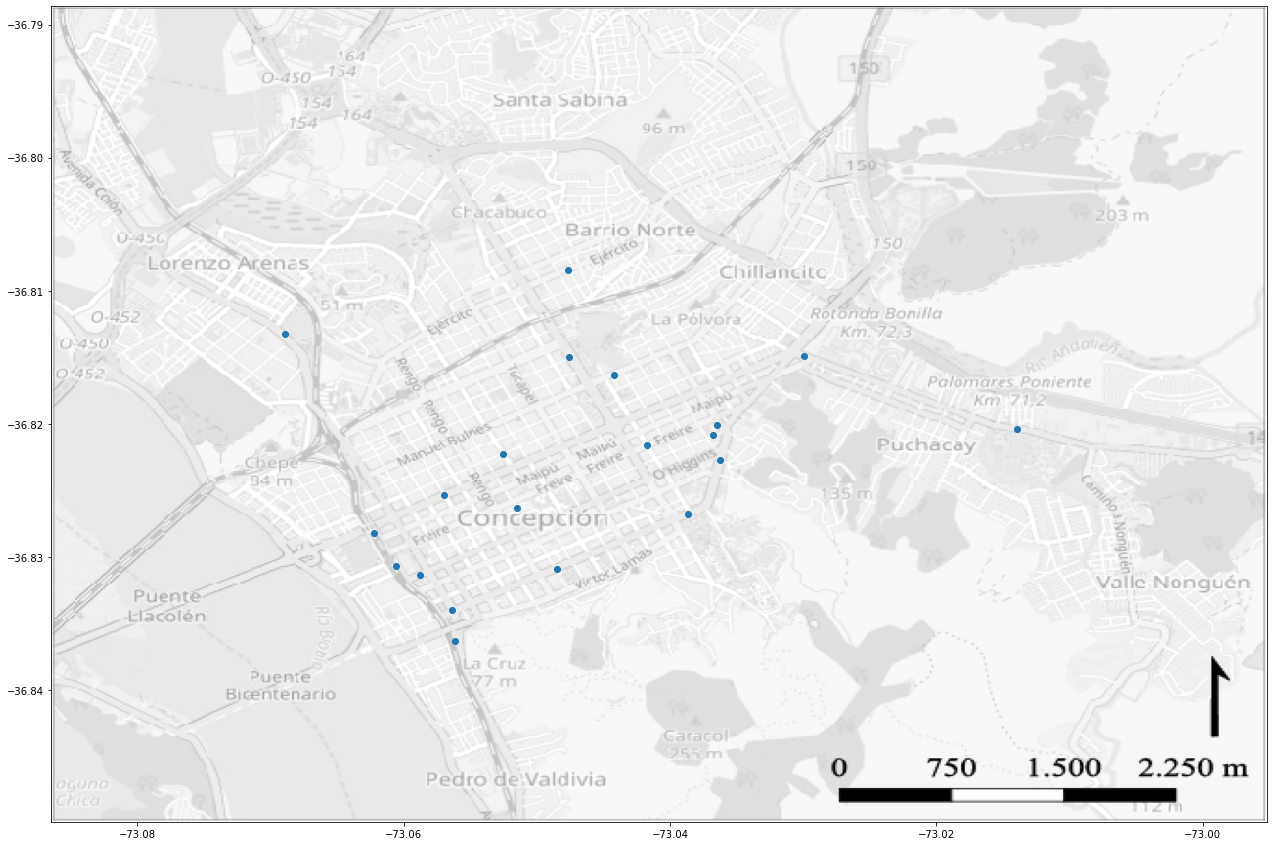

In [22]:
solucion_final = locations[res_inter[best_solutions[0]]]

import matplotlib.cbook as cbook

plt.figure(figsize = (25,15))

datafile = cbook.get_sample_data(f"{os.getcwd()}//map2.jpg")
img = plt.imread(datafile)
#plt.scatter(x,y,zorder=1)
plt.imshow(img, zorder=0, extent=[-73.08647, -72.9952, -36.84988, -36.78864])
plt.scatter(x = solucion_final[:,1], y = solucion_final[:,2])
plt.show()


In [23]:
sol_df = pd.DataFrame(locations[res_inter[best_solution]])
sol_df.columns = ['point_id','X','Y']
sol_df.to_csv("solucion_" + str(num_stations) + "_robust.csv",sep=';')

Calculating the percentage covered

In [25]:
# Calcular cobertura

A = pd.read_csv('tif_files/dist_entre_loc_dem.csv', sep = ';')   #filas 1295, columnas 615

A = A.iloc[:,2:].values.T  #filas 615, columnas 1295
A.shape   

(615, 1295)

In [26]:
demData = pd.read_excel('Data/Demands.xlsx')
demData = demData[['SHOPS', 'EDUCATION', 'BUS_STOPS', 'HOUSES']]

In [27]:
indices = np.argwhere(A[res_inter[best_solutions[0]]] < 250)
puntos_de_demanda = np.unique(indices[:,1])

In [28]:
demData.iloc[puntos_de_demanda,:].sum()

SHOPS        0.334992
EDUCATION    0.988143
BUS_STOPS    0.467000
HOUSES       0.130987
dtype: float64

# Calculating objective functions for the solution

In [29]:
Pvalue = num_stations
RobustPonds = json.load(open(f'results_{num_stations}_b/RobustLocDemand1.json'))

def functionRobust(pop):
    robustdemands = [RobustPonds[str(i)]['Min'] if i in pop else RobustPonds[str(i)]['Max'] for i in range(locLen)]
    fitness = sum(sorted(robustdemands, reverse=True)[:Pvalue]) - sum([robustdemands[i] for i in pop])
    return fitness

def functionLocDist(pop):
    fitness = 9999999999
    for i in pop:
        for j in pop:
            if(i!=j and Aloc[j*locLen+i][1] < fitness):
                fitness = Aloc[j*locLen+i][1]
    return fitness

In [30]:
Aloc = pickle.load(open("Data/dist_among_location.p","rb"))
demLen = 1295
locLen = 615

In [31]:
functionRobust(res_inter[best_solutions[0]])

0.25054540817043097

In [32]:
functionLocDist(res_inter[best_solutions[0]])

127.78110192771456

# Plot the percentage of the demand covered in our aproach vs other aproach. 

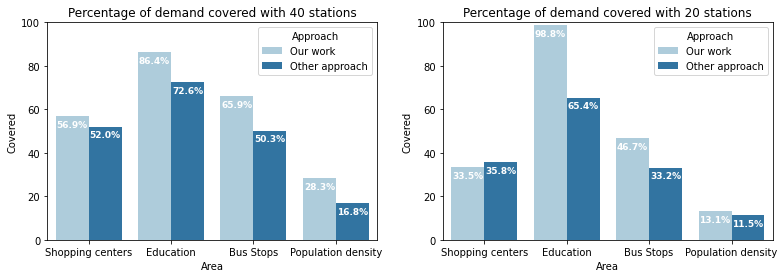

In [33]:
df = [["Shopping centers",0.569141, "Our work"], 
      ["Education", 0.863877, "Our work"], 
      ["Bus Stops", 0.659085, "Our work"], 
      ["Population density", 0.283214, "Our work"],
      ["Shopping centers",0.520234, "Other approach"], 
      ["Education", 0.726157, "Other approach"], 
      ["Bus Stops", 0.502534, "Other approach"], 
      ["Population density", 0.168384, "Other approach"]]

df = pd.DataFrame(df, columns = ['Area', 'Covered', 'Approach'])
df['Covered'] = df['Covered']*100

plt.figure(figsize = (13,4))
plt.subplot(121)
ax = sns.barplot(x = 'Area', y = 'Covered', hue = 'Approach', data = df, palette='Paired')
plt.title('Percentage of demand covered with 40 stations')

plt.yticks(range(0,101,20))

lista = np.hstack((np.arange(4) - 0.2, np.arange(4) + 0.2))

for index, row in df.iterrows():
    ax.text(lista[index], row['Covered'] - 5, f"{round(row['Covered'],1)}%" , color='white', ha="center", fontweight = 'semibold', size = 9)

df2 = [["Shopping centers",0.334992, "Our work"], 
      ["Education", 0.988143, "Our work"], 
      ["Bus Stops", 0.467000, "Our work"], 
      ["Population density", 0.130987, "Our work"],
      ["Shopping centers",0.357931, "Other approach"], 
      ["Education", 0.653643, "Other approach"], 
      ["Bus Stops", 0.331952, "Other approach"], 
      ["Population density", 0.114543, "Other approach"]]

df2 = pd.DataFrame(df2, columns = ['Area', 'Covered', 'Approach'])
df2['Covered'] = df2['Covered']*100

plt.subplot(122)    
ax = sns.barplot(x = 'Area', y = 'Covered', hue = 'Approach', data = df2, palette='Paired', capsize=0)
plt.title('Percentage of demand covered with 20 stations')
plt.yticks(range(0,102,20))
plt.ylim(0,100)

lista = np.hstack((np.arange(4) - 0.2, np.arange(4) + 0.2))

for index, row in df2.iterrows():
    ax.text(lista[index], row['Covered'] - 5, f"{round(row['Covered'],1)}%" , color='white', ha="center", fontweight = 'semibold', size = 9)    
    
    
plt.savefig('plot.pdf')    